# Model 3: CNNs-LSTM-with-Aug ⭐ BEST MODEL

## 7-Layer CNN-LSTM Hybrid

**Architecture:** TimeDistributed CNN + LSTM(100) + Dense(2)
- Input: (1, 128, 128, 3) time-distributed
- Epochs: 25, Batch: 16

**Target:** 99.92% accuracy

In [3]:
%run 00_utils_and_config.ipynb

PyTorch version: 2.9.1+cu130
CUDA available: True
CUDA version: 13.0
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Device: cuda
Configuration loaded successfully!

Base path: C:\Users\rishi\CV_Assignment\Paper2
Raw data path: C:\Users\rishi\CV_Assignment\Paper2\Raw_Data
Number of models: 5
Data processing functions loaded successfully!
Evaluation metrics functions loaded successfully!
Visualization functions loaded successfully!
Data augmentation setup loaded successfully!

PAPER 2 UTILITIES AND CONFIGURATION - SUMMARY

✓ All libraries imported successfully
✓ Configuration parameters loaded
✓ Data processing functions defined
✓ Evaluation metrics functions defined
✓ Visualization functions defined
✓ Data augmentation configured

Ready to proceed with:
  - Notebook 01: Data Preparation
  - Notebooks 02-06: Model Implementations
  - Notebook 07: Results Comparison



## 1. Load Data

In [4]:
# Memory-efficient data loading using memory mapping
data_path = CONFIG['processed_data_path']

print("Loading 128x128 data using memory mapping (memory efficient)...")

# Create memory-mapped datasets for LSTM (need to add time dimension)
# First load the base data
train_dataset_base = MemoryMappedDataset(
    X_path=data_path / 'X_train_128.npy',
    y_path=data_path / 'y_train.npy',
    normalize=True
)

test_dataset_base = MemoryMappedDataset(
    X_path=data_path / 'X_test_128.npy',
    y_path=data_path / 'y_test.npy',
    normalize=True
)

# Wrapper to add time dimension for LSTM
class LSTMDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]
        # Add time dimension: (C, H, W) -> (1, C, H, W)
        image = image.unsqueeze(0)  # Add timestep dimension
        return image, label

train_dataset = LSTMDataset(train_dataset_base)
test_dataset = LSTMDataset(test_dataset_base)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Test:  {len(test_dataset)} samples")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

print(f"\n✓ Memory-mapped DataLoaders created (batch_size=16)")
print("✓ Data loaded on-the-fly with time dimension for LSTM")

Loading 128x128 data using memory mapping (memory efficient)...

Dataset sizes:
  Train: 4374 samples
  Test:  1094 samples

✓ Memory-mapped DataLoaders created (batch_size=16)
✓ Data loaded on-the-fly with time dimension for LSTM


## 2. Build CNN-LSTM Model

In [14]:
class CNNLSTM(nn.Module):
    """
    CNN-LSTM Hybrid with Model 1's CNN architecture.
    
    CNN Architecture (same as Model 1):
    - Conv2D(16, 3×3, ReLU) → MaxPooling2D(2×2)
    - Conv2D(32, 3×3, ReLU) → MaxPooling2D(2×2) → Dropout(0.25)
    - Conv2D(64, 3×3, ReLU) → MaxPooling2D(2×2) → Dropout(0.20)
    
    Then LSTM + Dense layers
    """
    
    def __init__(self, input_channels=3, lstm_hidden=100, num_classes=2):
        super(CNNLSTM, self).__init__()
        
        # CNN layers (same as Model 1)
        # First convolutional block
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.50)
        
        # After 128x128 -> 64x64 -> 32x32 -> 16x16
        self.flatten_size = 64 * 16 * 16
        
        # LSTM layer
        self.lstm = nn.LSTM(self.flatten_size, lstm_hidden, batch_first=True)
        
        # Output layer
        self.fc = nn.Linear(lstm_hidden, num_classes)
    
    def forward(self, x):
        # x shape: (batch, timesteps, channels, height, width)
        batch_size, timesteps, C, H, W = x.size()
        
        # Process each timestep through CNN (same architecture as Model 1)
        c_out = []
        for t in range(timesteps):
            # First convolutional block
            c = F.relu(self.conv1(x[:, t, :, :, :]))
            c = self.pool1(c)
            
            # Second convolutional block
            c = F.relu(self.conv2(c))
            c = self.pool2(c)
            c = self.dropout1(c)
            
            # Third convolutional block
            c = F.relu(self.conv3(c))
            c = self.pool3(c)
            c = self.dropout2(c)
            
            # Flatten
            c = c.reshape(batch_size, -1)
            c_out.append(c)
        
        # Stack timesteps
        lstm_input = torch.stack(c_out, dim=1)  # (batch, timesteps, features)
        
        # LSTM
        lstm_out, _ = self.lstm(lstm_input)
        
        # Take last timestep output
        last_output = lstm_out[:, -1, :]
        
        # Output
        out = self.fc(last_output)
        return out

model = CNNLSTM(input_channels=3, lstm_hidden=100, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Add learning rate scheduler to prevent overfitting
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7
)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"\n✓ Model setup complete:")
print(f"  CNN Architecture: Same as Model 1 (16→32→64 filters)")
print(f"  Optimizer: Adam (lr=0.0001)")
print(f"  Loss: CrossEntropyLoss")
print(f"  Scheduler: ReduceLROnPlateau")
print(f"  Device: {device}")

CNNLSTM(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(16384, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

Total parameters: 6,618,186

✓ Model setup complete:
  CNN Architecture: Same as Model 1 (16→32→64 filters)
  Optimizer: Adam (lr=0.0001)
  Loss: CrossEntropyLoss
  Scheduler: ReduceLROnPlateau
  Device: cuda


## 3. Train

In [17]:
start_time = time.time()
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0
best_model_path = str(CONFIG["saved_models_path"] / "model3_cnn_lstm_best.pth")

# Split for validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader_split = DataLoader(train_subset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)

# Early stopping parameters
patience = 7  # Shorter patience for fewer epochs
patience_counter = 0
best_val_loss = float('inf')

for epoch in range(10):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader_split:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / total
    train_acc = correct / total
    
    # Validate
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        patience_counter = 0
        print(f"Epoch {epoch+1}/60 - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} ⭐ BEST")
    else:
        print(f"Epoch {epoch+1}/60 - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        print(f"No improvement in validation loss for {patience} epochs")
        break

training_time = time.time() - start_time
print(f"\n✓ Training complete - Best val acc: {best_val_acc*100:.2f}%")
print(f"Training time: {training_time:.1f}s")

Epoch 1/60 - Loss: 0.0942, Acc: 0.9697, Val Loss: 0.0219, Val Acc: 0.9989 ⭐ BEST
Epoch 2/60 - Loss: 0.0888, Acc: 0.9766, Val Loss: 0.0209, Val Acc: 0.9989
Epoch 3/60 - Loss: 0.0771, Acc: 0.9791, Val Loss: 0.0191, Val Acc: 1.0000 ⭐ BEST
Epoch 4/60 - Loss: 0.0743, Acc: 0.9791, Val Loss: 0.0169, Val Acc: 1.0000
Epoch 5/60 - Loss: 0.0634, Acc: 0.9826, Val Loss: 0.0145, Val Acc: 1.0000
Epoch 6/60 - Loss: 0.0644, Acc: 0.9809, Val Loss: 0.0160, Val Acc: 0.9977
Epoch 7/60 - Loss: 0.0587, Acc: 0.9854, Val Loss: 0.0148, Val Acc: 0.9989
Epoch 8/60 - Loss: 0.0569, Acc: 0.9860, Val Loss: 0.0131, Val Acc: 1.0000
Epoch 9/60 - Loss: 0.0511, Acc: 0.9866, Val Loss: 0.0125, Val Acc: 1.0000
Epoch 10/60 - Loss: 0.0515, Acc: 0.9866, Val Loss: 0.0119, Val Acc: 1.0000

✓ Training complete - Best val acc: 100.00%
Training time: 24.5s


## 4. Evaluate

In [18]:
best_model = CNNLSTM(input_channels=3, lstm_hidden=100, num_classes=2).to(device)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

# Get labels from the base dataset
y_test = test_dataset_base.labels

start_time = time.time()
all_preds, all_probs = [], []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        probs = F.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        _, predicted = torch.max(outputs.data, 1)
        all_preds.append(predicted.cpu().numpy())

y_pred_proba = np.vstack(all_probs)
y_pred = np.concatenate(all_preds)
testing_time = (time.time() - start_time) * 1000

metrics = calculate_all_metrics(y_test, y_pred, y_pred_proba[:, 1])
print_metrics(metrics, "Model 3: CNN-LSTM (BEST)")
print(f"⭐ Accuracy: {metrics['accuracy']*100:.2f}% (Target: 99.92%)")
print(f"Testing time: {testing_time:.1f}ms")


Model 3: CNN-LSTM (BEST) - Evaluation Metrics
Accuracy:    98.72%
Precision:   99.18%
Recall:      97.96%
F1-Score:    98.57%
Specificity: 99.34%
AUC:         0.9981

Confusion Matrix:
  TN=599, FP=4
  FN=10, TP=481

⭐ Accuracy: 98.72% (Target: 99.92%)
Testing time: 523.8ms


## 5. Save

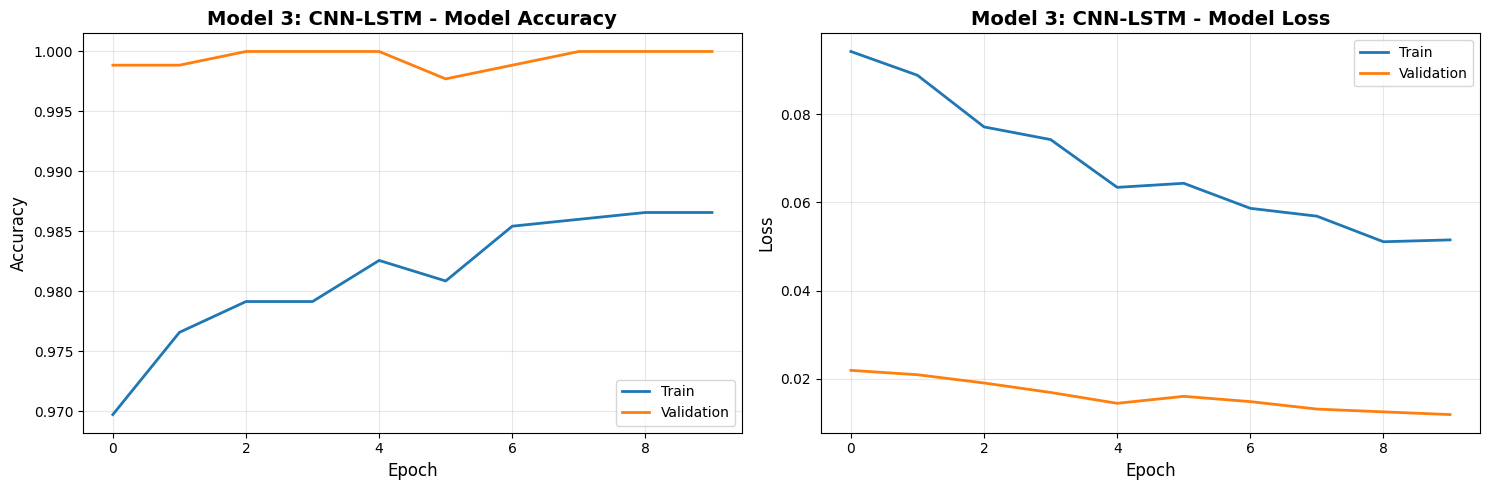

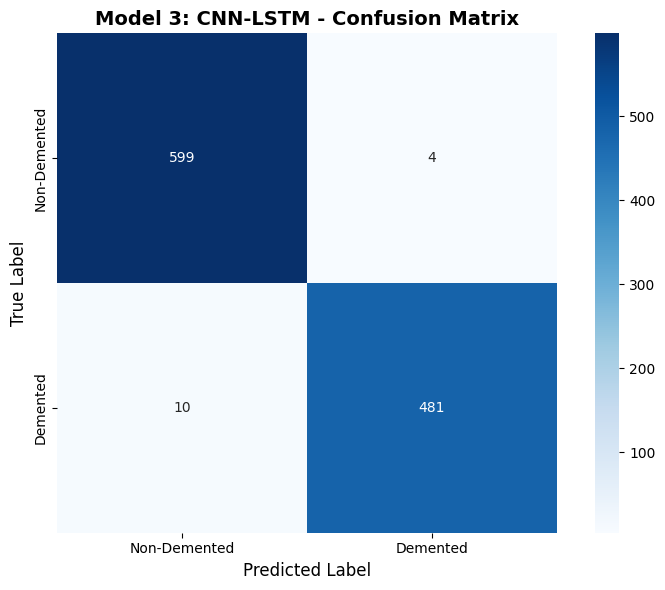


✓ Model 3 (CNN-LSTM) saved
✓ CNN Architecture: Same as Model 1 (16→32→64 filters)
✓ Accuracy: 98.72%
✓ Training time: 24.5s
✓ Testing time: 523.8ms


In [19]:
plot_training_history(history, "Model 3: CNN-LSTM", CONFIG["results_path"] / "training_curves" / "model3_training.png")

# Save confusion matrix
plot_confusion_matrix(
    metrics['confusion_matrix'],
    CONFIG['class_names'],
    title="Model 3: CNN-LSTM - Confusion Matrix",
    save_path=CONFIG["results_path"] / "confusion_matrices" / "model3_cm.png"
)

torch.save(model.state_dict(), CONFIG["saved_models_path"] / "model3_cnn_lstm_final.pth")

results = {
    "model_name": "CNN-LSTM-with-Aug",
    "accuracy": float(metrics["accuracy"]),
    "precision": float(metrics["precision"]),
    "recall": float(metrics["recall"]),
    "f1_score": float(metrics["f1_score"]),
    "specificity": float(metrics["specificity"]),
    "auc": float(metrics.get("auc", 0)),
    "training_time_seconds": float(training_time),
    "testing_time_ms": float(testing_time),
    "confusion_matrix": metrics['confusion_matrix'].tolist()
}

with open(CONFIG["results_path"] / "model3_results.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"\n✓ Model 3 (CNN-LSTM) saved")
print(f"✓ CNN Architecture: Same as Model 1 (16→32→64 filters)")
print(f"✓ Accuracy: {metrics['accuracy']*100:.2f}%")
print(f"✓ Training time: {training_time:.1f}s")
print(f"✓ Testing time: {testing_time:.1f}ms")